# Gemma - Translator of Traditional Chinese Poetry 



## Install dependencies

Install Keras and KerasNLP.

In [1]:
# Install Keras 3 last. See https://keras.io/getting_started/ for more details.
!pip install -q -U keras-nlp datasets
!pip install -q -U keras

import os

# Set the backbend before importing Keras
os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

import keras_nlp
import keras

# Run at half precision.
#keras.config.set_floatx("bfloat16")

# Training Configurations
token_limit = 256
lora_name = "translator"
lora_rank = 4
lr_value = 1e-4
train_epoch = 5
model_id = "gemma2_instruct_2b_en"

## Load Dataset


In [2]:
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)

from datasets import load_dataset

ds = load_dataset(
    "honganzhu/watermelody",
    split="train",
)
print(ds)
data = ds.with_format(
    "np", columns=["input", "output"], output_all_columns=False
)
train = []

for x in data:
    item = f"<start_of_turn>user\n{x['input']}<end_of_turn>\n<start_of_turn>model\n{x['output']}<end_of_turn>"
    length = len(tokenizer(item))
    # skip data if the token length is longer than our limit
    if length < token_limit:
        train.append(item)

print(len(train))
print(train[0])
print(train[1])
print(train[2])


normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


README.md:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14 [00:00<?, ? examples/s]

Dataset({
    features: ['input', 'output'],
    num_rows: 14
})
14
<start_of_turn>user
明月几时有?<end_of_turn>
<start_of_turn>model
How long will the full moon appear<end_of_turn>
<start_of_turn>user
把酒问青天<end_of_turn>
<start_of_turn>model
Wine cup in hand, I ask the sky<end_of_turn>
<start_of_turn>user
不知天上宫阙，今夕是何年<end_of_turn>
<start_of_turn>model
I do not know what time of the year, ’Twould be tonight in the palace on high<end_of_turn>


## Load Model

In [3]:
import keras
import keras_nlp

import time

gemma = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma.summary()

tick_start = 0


def tick():
    global tick_start
    tick_start = time.time()


def tock():
    print(f"TOTAL TIME ELAPSED: {time.time() - tick_start:.2f}s")


def text_gen(prompt):
    tick()
    input = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"
    output = gemma.generate(input, max_length=token_limit)
    print("\nGemma output:")
    print(output)
    tock()


text_gen("水光潋滟晴方好")
text_gen("山色空蒙雨亦奇")
text_gen("欲把西湖比西子")
text_gen("淡妆浓抹总相宜")

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)


Gemma output:
<start_of_turn>user
水光潋滟晴方好<end_of_turn>
<start_of_turn>model
This is a beautiful and evocative Chinese phrase!  It translates to:

**"The water sparkles and reflects the clear sky, what a beautiful day!"**

Here's a breakdown of why it's so appealing:

* **水光潋滟 (shuǐ guāng lián yán):** This describes the shimmering, sparkling effect of water, often caused by sunlight reflecting off its surface. 
* **晴方好 (qíng fāng hǎo):** This means "a beautiful day" or "a good day."

**The phrase evokes a sense of:**

* **Tranquility:** The image of water reflecting the sky creates a sense of peace and serenity.
* **Beauty:** The sparkling water is visually stunning and evokes a feeling of joy.
* **Hope:** The phrase suggests a bright and optimistic outlook on life.

It's a perfect phrase to capture the essence of a beautiful day. 


Do you have any other Chinese phrases you'd like to explore? 
<end_of_turn>
TOTAL TIME ELAPSED: 24.67s

Gemma output:
<start_of_turn>user
山色空蒙雨亦奇<end_of_t

## LoRA Fine-tuning

In [4]:
# Enable LoRA for the model and set the LoRA rank (4, 8 or 16).
gemma.backbone.enable_lora(rank=lora_rank)
gemma.summary()

# Limit the input sequence length (to control memory usage).
gemma.preprocessor.sequence_length = token_limit
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_value,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

## Save LoRA for each epoch

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.0053 - sparse_categorical_accuracy: 0.2015 
Gemma output:
<start_of_turn>user
水光潋滟晴方好<end_of_turn>
<start_of_turn>model
This is a beautiful and evocative Chinese phrase!  It translates to:

**"The water sparkles and reflects the clear sky, what a beautiful day!"**

Here's a breakdown of why it's so appealing:

* **水光潋滟 (shuǐ guāng lián yán):** This describes the shimmering, sparkling effect of water, often used to evoke a sense of beauty and tranquility.
* **晴方好 (qíng fāng hǎo):** This means "a good day," emphasizing the positive and joyful feeling associated with a clear sky.

**Overall, the phrase paints a vivid picture of a perfect day, filled with beauty and serenity.** 

It's a lovely sentiment that captures the essence of a clear, sunny day. 
<end_of_turn>
TOTAL TIME ELAPSED: 24.49s

Gemma output:
<start_of_turn>user
山色空蒙雨亦奇<end_of_turn>
<start_of_turn>model
This is a beautiful and evocative line from a Chinese poem!  It t

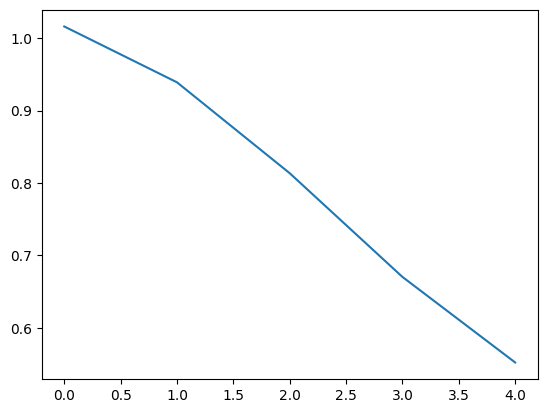

In [5]:
class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    model_name = f"/kaggle/working/{lora_name}_{lora_rank}_epoch{epoch+1}.lora.h5"
    gemma.backbone.save_lora_weights(model_name)

    # Evaluate
    text_gen("水光潋滟晴方好")
    text_gen("山色空蒙雨亦奇")
    text_gen("欲把西湖比西子")
    text_gen("淡妆浓抹总相宜")

history = gemma.fit(train, epochs=train_epoch, batch_size=1, callbacks=[CustomCallback()])

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.show()
